# Train mask over IOI edges and analyze mask vs known circuit

In [1]:
import os
os.chdir("/data/phillip_guo/circuit-breaking/ioi/")
from models import load_gpt2_weights, load_demo_gpt2, tokenizer
from data import retrieve_toxic_data, retrieve_owt_data, retrieve_toxic_data_low_loss, retrieve_toxic_filtered_data, FILTER_DEMO_LEN, CONTEXT_LENGTH
from inference import infer_batch_with_owt, infer_batch, prepare_fixed_demo, criterion
from torch.optim import AdamW
import torch
import pickle
import datasets
from tqdm import tqdm_notebook as tqdm
from itertools import cycle
# from eval import evaluate_model
from data import batch_text_to_tokens
import plotly.express as px

Using device: cuda:0


## Load mask into model

In [2]:
means_ioi = True

if means_ioi:
    with open("data/gpt2_ioi_abc_means.pkl", "rb") as f:
        means = pickle.load(f)[0]
else:
    with open("data/gpt2_means.pkl", "rb") as f:
        means = pickle.load(f)[0]

model = load_demo_gpt2(means=means)

In [3]:
means.shape

torch.Size([50, 157, 768])

In [4]:
template_type = "single"
alpha = 1

with open(f"models/alternative_necessary_masks_params_dict_lambda=1_{alpha=}_{means_ioi=}_{template_type=}.pkl", "rb") as f:
    necessary_masks_dict = pickle.load(f)
with open(f"models/alternative_sufficient_masks_params_dict_lambda=1_{alpha=}_{means_ioi=}_{template_type=}.pkl", "rb") as f:
    sufficient_masks_dict = pickle.load(f)
with open(f"models/params_dict_lambda=1_{means_ioi=}_{template_type=}.pkl", "rb") as f:
    mask_params_dict = pickle.load(f)
with open("models/acdcpp_mask_params.pkl", "rb") as f:
    acdcpp_mask_params = pickle.load(f)
with open("models/circuit_covering_circuit_breaking_params_dict_lambda=1_alpha=0.2_means_ioi=False_template_type='single'.pkl", "rb") as f:
    cb_circuit_covering_masks_dict = pickle.load(f)
with open("models/circuit_covering_alternative_necessary_params_dict_lambda=1_alpha=1_means_ioi=False_template_type='single'.pkl", "rb") as f:
    necessary_circuit_covering_masks_dict = pickle.load(f)


final_masks = {"necessary": necessary_masks_dict[200], "sufficient": sufficient_masks_dict[200], "acdcpp": acdcpp_mask_params, "circuit_breaking": mask_params_dict[200], "cb_circuit_covering": cb_circuit_covering_masks_dict[200], "necessary_circuit_covering": necessary_circuit_covering_masks_dict[200]}

In [5]:
def load_mask_into_model(model, mask):
    # load in place
    mask_idx = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            with torch.no_grad():
                mask[mask_idx].requires_grad = False
                param.copy_(mask[mask_idx])
                mask_idx += 1

def reset_mask(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            with torch.no_grad():
                param.copy_(torch.ones_like(param.data))

## Test model before and after circuit breaking

In [6]:
import pickle
with open("data/ioi_prompts_single_template_test.pkl", "rb") as f:
    ioi_prompts_test = pickle.load(f)
    # ioi_sentences_test = [t[2] for t in ioi_sentences_test]

with open("data/eval_uniform.pkl", "rb") as f:
    uniform_samples = pickle.load(f)
    uniform_sentences = [t[2] for t in uniform_samples]

In [7]:
toxic_data_loader = retrieve_toxic_data(50, 16, tokenizer, tokenize=False, num_points=None, template_type=template_type, split='test')
owt_data_loader = retrieve_owt_data(50, split='train')

In [8]:
# Run inference on an ioi_sentence
ioi_prompt = ioi_prompts_test[0]
print(ioi_prompt)

model.eval()
model.to('cuda')
def get_last_token(model, prompt, topk=5, sentence=False):
    # generate last token
    if not sentence:
        prompt_sentence = prompt['text']
    else:
        prompt_sentence = prompt

    tokens = tokenizer(prompt_sentence, return_tensors='pt').input_ids[:, :-1]

    # generate one token, decode original_model(ioi_tokens[:, :-1])
    model_outputs = model(tokens)[0]
    model_outputs = model_outputs.squeeze(0)[-1]
    probs = torch.nn.functional.softmax(model_outputs, dim=-1)

    topk_outputs = torch.topk(model_outputs, topk)
    topk_tokens = topk_outputs.indices
    topk_probs = probs[topk_outputs.indices]
    
    topk_tokens_decoded = tokenizer.batch_decode(topk_tokens)
    
    if not sentence:
        # Get logit diff by finding difference between logit of 
        io_token = tokenizer(" " + prompt['IO'], return_tensors='pt').input_ids[:, -1]
        s_token = tokenizer(" " + prompt['S'], return_tensors='pt').input_ids[:, -1]
        logit_diff = model_outputs[io_token][0] - model_outputs[s_token][0]
        return topk_tokens_decoded, topk_probs, logit_diff
    return topk_tokens_decoded, topk_probs

# get IOI logit diff
def get_ioi_score(model, num_samples):
    ave_logit_diffs = []
    for idx in range(num_samples):
        prompt = ioi_prompts_test[idx]
        ave_logit_diffs.append(get_last_token(model, prompt)[2])
    return sum(ave_logit_diffs) / len(ave_logit_diffs)

# get IOI and OWT loss
def get_losses(model, num_batches):
    ioi_iter = cycle(toxic_data_loader)
    owt_iter = cycle(owt_data_loader)
    ioi_losses = []
    owt_losses = []
    for idx in range(num_batches):
        with torch.no_grad():
            ioi_loss, owt_loss = infer_batch_with_owt(model, criterion, next(ioi_iter), next(owt_iter), 10, torch.zeros((0,0)), access_toxic_pos=-1)
        ioi_losses.append(ioi_loss) 
        owt_losses.append(owt_loss)
    return torch.stack(ioi_losses), torch.stack(owt_losses)

{'[PLACE]': 'house', '[OBJECT]': 'ring', 'text': 'Then, Sarah and Amanda went to the house. Amanda gave a ring to Sarah', 'IO': 'Sarah', 'S': 'Amanda', 'TEMPLATE_IDX': 0}


In [16]:
import numpy as np
from collections import defaultdict
# For every mask, throughout training, get the IOI logit diff and OWT loss
ioi_losses = defaultdict(list)
owt_losses = defaultdict(list)
ioi_scores = defaultdict(list)

for training_epochs in tqdm(np.arange(20, 220, 20)):
    masks = {"necessary": necessary_masks_dict[training_epochs], "sufficient": sufficient_masks_dict[training_epochs], "circuit_breaking": mask_params_dict[training_epochs], "cb_circuit_covering": cb_circuit_covering_masks_dict[training_epochs], "necessary_circuit_covering": necessary_circuit_covering_masks_dict[training_epochs]}

    for mask_type, mask in tqdm(masks.items()):
        with torch.no_grad():
            reset_mask(model)
            load_mask_into_model(model, mask)
            ioi_loss, owt_loss = get_losses(model, 50)
            ioi_losses[mask_type].append(ioi_loss.mean().item())
            owt_losses[mask_type].append(owt_loss.mean().item())
            ioi_scores[mask_type].append(get_ioi_score(model, 20).item())
            # collect cuda garbage
            torch.cuda.empty_cache()


/tmp/ipykernel_233053/4252065065.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for training_epochs in tqdm(np.arange(20, 220, 20)):


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_233053/4252065065.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mask_type, mask in tqdm(masks.items()):


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
with open("data/losses_and_scores.pkl", "wb") as f:
    pickle.dump((ioi_losses, owt_losses, ioi_scores), f)

: 

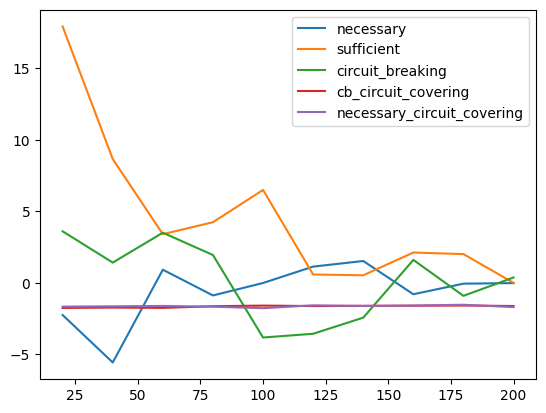

In [ ]:
# Graph IOI logit diff in one graph, OWT and IOI Loss in another graph
import matplotlib.pyplot as plt
# First IOI logit diff
for mask_type, ioi_score in ioi_scores.items():
    plt.plot(np.arange(20, 220, 20), ioi_score, label=mask_type)
plt.xlabel("Training Epochs")
plt.ylabel("IOI Logit Diff")
plt.legend()
plt.title("IOI Logit Diff over Training Epochs")
plt.show()

In [ ]:
# Now, plot IOI and OWT loss, IOI dotted line, OWT solid line
for mask_type, ioi_loss in ioi_losses.items():
    plt.plot(np.arange(20, 220, 20), ioi_loss, label=f"IOI {mask_type}", linestyle='-')
for mask_type, owt_loss in owt_losses.items():
    plt.plot(np.arange(20, 220, 20), owt_loss, label=f"OWT {mask_type}", linestyle='--')
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("IOI and OWT Loss over Training Epochs")
plt.show()

AttributeError: 'list' object has no attribute 'items'

In [11]:
def invert_mask(mask, keep_output=True):
    new_mask = []
    for idx, m in enumerate(mask):
        if idx == 0 and keep_output:
            new_mask.append(torch.ones_like(m))
        else:
            new_mask.append(1 - m)
    return new_mask

In [12]:
reset_mask(model)
print("Average logit diff with no edges masked: ", get_ioi_score(model, 20))

load_mask_into_model(model, necessary_masks_dict[200])
print(f"Average logit diff with necessary edges masked: {get_ioi_score(model, 50)}")

load_mask_into_model(model, sufficient_masks_dict[200])
print(f"Average logit diff with sufficient edges masked: {get_ioi_score(model, 50)}")

load_mask_into_model(model, mask_params_dict[200])
print(f"Average logit diff post circuit-breaking: {get_ioi_score(model, 50)}")

load_mask_into_model(model, acdcpp_mask_params)
print(f"Average logit diff post masking ACDC++: {get_ioi_score(model, 50)}")

Average logit diff with no edges masked:  tensor(3.7131, device='cuda:0', grad_fn=<DivBackward0>)
Average logit diff with necessary edges masked: -0.3458968997001648
Average logit diff with sufficient edges masked: 18.609237670898438
Average logit diff post circuit-breaking: -0.4131331443786621
Average logit diff post masking ACDC++: -1.7468138933181763


In [13]:
acdcpp_mask_params

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
         0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.], device='cuda:0'),
 tensor([[0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.]]),
 tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 

In [14]:
# load_mask_into_model(model, invert_mask(acdcpp_mask_params))
load_mask_into_model(model, final_masks['sufficient'])
with torch.no_grad():
    test_ioi_sentences = ["While Alicia and Joshua were commuting to the restaurant, Joshua gave a snack to", "While Joshua and Alicia were commuting to the restaurant, Joshua gave a snack to"]
    for test_ioi_sentence in test_ioi_sentences:
        correct_token_id = tokenizer.encode(" Alicia", return_tensors="pt").squeeze().item()
        other_token_id = tokenizer.encode(" Joshua", return_tensors="pt").squeeze().item()
        test_ioi_tokens = tokenizer.encode(test_ioi_sentence, return_tensors="pt").to('cuda')
        generation = model(test_ioi_tokens)[0][:, -1]
        probs = torch.softmax(generation, dim=-1)
        print(f"Best Token: {tokenizer.batch_decode(torch.argmax(generation, dim=-1))}, P(Alicia) = {probs[:,correct_token_id].item()}, logit diff = {generation[:,correct_token_id].item() - generation[:,other_token_id].item()}")

Best Token: [' Alicia'], P(Alicia) = 0.8985728621482849, logit diff = 2.338129997253418
Best Token: [' Joshua'], P(Alicia) = 2.0893772045837977e-08, logit diff = -17.600988388061523


In [10]:
print("Inverted Masks")
reset_mask(model)
print("Average logit diff with no edges masked: ", get_ioi_score(model, 20))

load_mask_into_model(model, invert_mask(necessary_masks_dict[200]))
print(f"Average logit diff with necessary edges masked: {get_ioi_score(model, 100)}")

load_mask_into_model(model, invert_mask(sufficient_masks_dict[200]))
print(f"Average logit diff with sufficient edges masked: {get_ioi_score(model, 100)}")

load_mask_into_model(model, invert_mask(mask_params_dict[200]))
print(f"Average logit diff post circuit-breaking: {get_ioi_score(model, 100)}")

load_mask_into_model(model, invert_mask(acdcpp_mask_params))
print(f"Average logit diff post masking ACDC++: {get_ioi_score(model, 100)}")

Inverted Masks
Average logit diff with no edges masked:  tensor(2.9523, device='cuda:0', grad_fn=<DivBackward0>)
Average logit diff with necessary edges masked: -0.0035178374964743853
Average logit diff with sufficient edges masked: -1.110324740409851
Average logit diff post circuit-breaking: 0.003694457933306694
Average logit diff post masking ACDC++: 0.06923042237758636


In [13]:
import nvsmi

nvsmi.get_gpus()
nvsmi.get_available_gpus()
nvsmi.get_gpu_processes()

[pid: 187963 | gpu_id: 0 | gpu_uuid: GPU-23af42b5-2478-0724-7712-899809c890ac | gpu_name: NVIDIA A100-SXM4-80GB | used_memory:  9212.0MB,
 pid: 188436 | gpu_id: 0 | gpu_uuid: GPU-23af42b5-2478-0724-7712-899809c890ac | gpu_name: NVIDIA A100-SXM4-80GB | used_memory:  5264.0MB,
 pid: 230888 | gpu_id: 0 | gpu_uuid: GPU-23af42b5-2478-0724-7712-899809c890ac | gpu_name: NVIDIA A100-SXM4-80GB | used_memory: 27400.0MB]

## Manually Check Edges

In [6]:
name_mover_heads = ['a10.0', 'a9.9', 'a9.6']
negative_heads = ['a10.7', 'a11.10']
s2_inhibition_heads = ['a8.10', 'a7.9', 'a8.6', 'a7.3']
induction_heads = ['a5.5', 'a6.9', 'a5.9', 'a5.8']
duplicate_token_heads = ['a0.1', 'a0.10', 'a3.0']
previous_token_heads = ['a4.11', 'a2.2', 'a2.9']
backup_name_mover_heads = ['a11.2', 'a10.2', 'a10.6', 'a10.1', 'a10.10', 'a9.7', 'a11.9', 'a11.3']
input_nodes = ['embed']
output_nodes = ["output"]

circuit_dict = {}

for head in name_mover_heads:
    circuit_dict[(int(head.split('.')[0][1:]), head)] = 'name_mover'

for head in negative_heads:
    circuit_dict[(int(head.split('.')[0][1:]), head)] = 'negative'

for head in s2_inhibition_heads:
    circuit_dict[(int(head.split('.')[0][1:]), head)] = 's2_inhibition'

for head in induction_heads:
    circuit_dict[(int(head.split('.')[0][1:]), head)] = 'induction'

for head in duplicate_token_heads:
    circuit_dict[(int(head.split('.')[0][1:]), head)] = 'duplicate_token'

for head in previous_token_heads:
    circuit_dict[(int(head.split('.')[0][1:]), head)] = 'previous_token'

for head in backup_name_mover_heads:
    circuit_dict[(int(head.split('.')[0][1:]), head)] = 'backup_name_mover'

circuit_dict[(-1, 'embed')] = 'embed'
circuit_dict[(12, 'output')] = 'output'

In [7]:
# get all possible edges, between any heads in the circuit
all_possible_circuit_edges = set()
for head in circuit_dict:
    for head_2 in circuit_dict:
        if head != head_2 and head[0] > head_2[0]:
            print(f"{head} -> {head_2}")
            all_possible_circuit_edges.add((head, head_2))

(10, 'a10.0') -> (9, 'a9.9')
(10, 'a10.0') -> (9, 'a9.6')
(10, 'a10.0') -> (8, 'a8.10')
(10, 'a10.0') -> (7, 'a7.9')
(10, 'a10.0') -> (8, 'a8.6')
(10, 'a10.0') -> (7, 'a7.3')
(10, 'a10.0') -> (5, 'a5.5')
(10, 'a10.0') -> (6, 'a6.9')
(10, 'a10.0') -> (5, 'a5.9')
(10, 'a10.0') -> (5, 'a5.8')
(10, 'a10.0') -> (0, 'a0.1')
(10, 'a10.0') -> (0, 'a0.10')
(10, 'a10.0') -> (3, 'a3.0')
(10, 'a10.0') -> (4, 'a4.11')
(10, 'a10.0') -> (2, 'a2.2')
(10, 'a10.0') -> (2, 'a2.9')
(10, 'a10.0') -> (9, 'a9.7')
(10, 'a10.0') -> (-1, 'embed')
(9, 'a9.9') -> (8, 'a8.10')
(9, 'a9.9') -> (7, 'a7.9')
(9, 'a9.9') -> (8, 'a8.6')
(9, 'a9.9') -> (7, 'a7.3')
(9, 'a9.9') -> (5, 'a5.5')
(9, 'a9.9') -> (6, 'a6.9')
(9, 'a9.9') -> (5, 'a5.9')
(9, 'a9.9') -> (5, 'a5.8')
(9, 'a9.9') -> (0, 'a0.1')
(9, 'a9.9') -> (0, 'a0.10')
(9, 'a9.9') -> (3, 'a3.0')
(9, 'a9.9') -> (4, 'a4.11')
(9, 'a9.9') -> (2, 'a2.2')
(9, 'a9.9') -> (2, 'a2.9')
(9, 'a9.9') -> (-1, 'embed')
(9, 'a9.6') -> (8, 'a8.10')
(9, 'a9.6') -> (7, 'a7.9')
(9, 'a9.

In [8]:
# Convert edges back to weight mask
from mask_utils import get_nodes_and_edges

all_possible_nodes, nodes_with_edges, edges, mask_dict = get_nodes_and_edges(acdcpp_mask_params)
def get_mask_from_edges(edges, weight_mask_template=mask_dict, all_possible_nodes=all_possible_nodes, edge_0=True):
    new_mask_dict = {}
    for node_name in weight_mask_template:
        new_mask_dict[node_name] = torch.ones_like(weight_mask_template[node_name]) if edge_0 else torch.zeros_like(weight_mask_template[node_name])
    
    node_indices = {node_name: idx for idx, node_name in enumerate(all_possible_nodes)}
    for edge in edges:
        try:
            new_mask_dict[edge[0][1]][node_indices[edge[1]]] = 0 if edge_0 else 1
        except:
            continue
    
    return new_mask_dict

def convert_mask_dict_to_params(mask_dict):
    mask_params = []
    # first output_mask
    mask_params.append(mask_dict["output"])
    for layer in range(12):
        attn_tensors = []
        for head in range(12):
            attn_tensors.append(mask_dict[f"a{layer}.{head}"])
        mask_params.append(torch.stack(attn_tensors, dim=1))
        mask_params.append(mask_dict[f"m{layer}"])
    return mask_params

circuit_covering_mask_dict = get_mask_from_edges(all_possible_circuit_edges, edge_0=True)
circuit_covering_mask_params = convert_mask_dict_to_params(circuit_covering_mask_dict)
with open("models/circuit_covering_mask_params.pkl", "wb") as f:
    pickle.dump(circuit_covering_mask_params, f)

In [9]:
def check_relevant_edges(mask_edges, circuit_nodes=circuit_dict):
    # edges where one of the nodes is in the circuit
    relevant_edges = []

    # edges where both nodes are in the circuit
    circuit_edges = []
    
    for edge in mask_edges:
        if edge[0] in circuit_nodes or edge[1] in circuit_nodes:
            relevant_edges.append(edge)
        if edge[0] in circuit_nodes and edge[1] in circuit_nodes:
            circuit_edges.append(edge)
    return relevant_edges, circuit_edges

In [10]:
from mask_utils import get_nodes_and_edges

for name, mask in final_masks.items():
    print(name)
    _, _, edges, _ = get_nodes_and_edges(mask, edge_0=(False if name == "sufficient" else True))
    relevant_edges, circuit_edges = check_relevant_edges(edges)
    print(f"For {name}, number of relevant edges: {len(relevant_edges)}, number of circuit edges: {len(circuit_edges)}, total number of edges: {len(edges)}")
# _, _, sufficient_edges, _ = get_nodes_and_edges(necessary_masks_dict[200])
# relevant_edges, circuit_edges = check_relevant_edges(sufficient_edges)
# print(f"number of relevant edges: {len(relevant_edges)}, number of circuit edges: {len(circuit_edges)}")

# _, _, acdcpp_edges, _ = get_nodes_and_edges(acdcpp_mask_params)
# relevant_edges, circuit_edges = check_relevant_edges(acdcpp_edges)
# print(f"number of relevant edges: {len(relevant_edges)}, number of circuit edges: {len(circuit_edges)}")

necessary
For necessary, number of relevant edges: 164, number of circuit edges: 16, total number of edges: 388
sufficient
For sufficient, number of relevant edges: 1, number of circuit edges: 0, total number of edges: 8
acdcpp
For acdcpp, number of relevant edges: 3697, number of circuit edges: 296, total number of edges: 11379
circuit_breaking
For circuit_breaking, number of relevant edges: 92, number of circuit edges: 9, total number of edges: 237
cb_circuit_covering
For cb_circuit_covering, number of relevant edges: 15, number of circuit edges: 15, total number of edges: 15
necessary_circuit_covering
For necessary_circuit_covering, number of relevant edges: 67, number of circuit edges: 67, total number of edges: 67


In [11]:
for epochs_trained in sufficient_masks_dict:
    _, _, sufficient_edges, _ = get_nodes_and_edges(sufficient_masks_dict[epochs_trained], edge_0=False)
    relevant_edges, circuit_edges = check_relevant_edges(sufficient_edges)
    if len(circuit_edges) > 0:
        print(f"{epochs_trained} epochs trained, number of relevant edges: {len(relevant_edges)}, number of circuit edges: {len(circuit_edges)}")

10 epochs trained, number of relevant edges: 452, number of circuit edges: 39
20 epochs trained, number of relevant edges: 357, number of circuit edges: 27
50 epochs trained, number of relevant edges: 45, number of circuit edges: 5
90 epochs trained, number of relevant edges: 2, number of circuit edges: 1
100 epochs trained, number of relevant edges: 9, number of circuit edges: 2


In [12]:
# Get overlaps between each edge set
n_epochs = 100
edges_dict = {"necessary": get_nodes_and_edges(necessary_masks_dict[n_epochs], edge_0=True)[2], "sufficient": get_nodes_and_edges(sufficient_masks_dict[n_epochs], edge_0=False)[2], "acdcpp": get_nodes_and_edges(acdcpp_mask_params, edge_0=False)[2], "circuit_breaking": get_nodes_and_edges(mask_params_dict[n_epochs], edge_0=True)[2], "necessary_circuit_covering": get_nodes_and_edges(necessary_circuit_covering_masks_dict[n_epochs], edge_0=True)[2], "cb_circuit_covering": get_nodes_and_edges(cb_circuit_covering_masks_dict[n_epochs], edge_0=True)[2]}

# make a 6x6 matrix of intersections between the sets of edges
import pandas as pd

# Assuming you already have the sets from your dictionary
# For demonstration, let's consider these are your sets:

set_names = edges_dict.keys()
sets = edges_dict.values()

# Initialize an empty matrix
matrix = []

# Calculate the intersections
for set1 in sets:
    row = []
    for set2 in sets:
        # Append the length of intersection to the row
        row.append(len(set1.intersection(set2)))
    # Append the row to the matrix
    matrix.append(row)

# Create a DataFrame from the matrix
df = pd.DataFrame(matrix, index=set_names, columns=set_names)

# Display the DataFrame
df

,necessary,sufficient,acdcpp,circuit_breaking,necessary_circuit_covering,cb_circuit_covering
necessary,966,14,48,91,10,3
sufficient,14,39,12,2,0,0
acdcpp,48,12,232,17,28,19
circuit_breaking,91,2,17,438,5,3
necessary_circuit_covering,10,0,28,5,100,32
cb_circuit_covering,3,0,19,3,32,33


In [78]:
# Initialize an empty matrix
matrix = []

# Calculate the intersections
for set1 in sets:
    row = []
    for set2 in sets:
        # Append the length of intersection to the row
        row.append(f"{round(len(set1.intersection(set2)) / len(set1) * 100, 2)}%")
    # Append the row to the matrix
    matrix.append(row)

# Create a DataFrame from the matrix
proportional_df = pd.DataFrame(matrix, index=set_names, columns=set_names)

# Display the DataFrame
proportional_df

,necessary,sufficient,acdcpp,circuit_breaking,necessary_circuit_covering,cb_circuit_covering
necessary,1.0,0.01,0.04,0.07,0.01,0.0
sufficient,0.01,1.0,0.05,0.0,0.0,0.0
acdcpp,0.04,0.05,1.0,0.03,0.09,0.08
circuit_breaking,0.07,0.0,0.03,1.0,0.01,0.01
necessary_circuit_covering,0.01,0.0,0.09,0.01,1.0,0.32
cb_circuit_covering,0.0,0.0,0.08,0.01,0.32,1.0


In [ ]:
# calculate correlations between the sets of edges
import scipy.stats as stats

# get size of overlap vs 

## Visualize mask
Create the computational graphs in edge attribution patching paper

### Load mask and calculate what edges are present

In [16]:
# get param names
param_names = []
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names.append(name)

def get_nodes_and_edges(mask_params, edge_0=True):
    """
    If edge_0 is True, then edges are between nodes with mask value 0. Else, edges are between nodes with mask value 1.
    """
    # calculate which nodes will be in the graph
    connected_nodes = set()
    # add embed node at position
    # connected_nodes.add((-1, "embed"))
    n_heads = 12
    n_layers = 12

    # associate each node with a position
    all_possible_nodes = [(-1, "embed")]
    mask_dict = {}
    # empty tensor
    mask_dict["embed"] = torch.zeros(size=(0,))
    for idx in range(len(mask_params)):
        if "attention" in param_names[idx]:
            layer = int(param_names[idx].split(".")[1])
            for i in range(n_heads):
                all_possible_nodes.append((layer, f"a{layer}.{i}"))
                mask_dict[f"a{layer}.{i}"] = mask_params[idx][:,i].detach().cpu()
        elif "mlp" in param_names[idx]:
            layer = int(param_names[idx].split(".")[1])
            all_possible_nodes.append((layer, f"m{layer}"))
            mask_dict[f"m{layer}"] = mask_params[idx].detach().cpu()
    all_possible_nodes.append((n_heads, "output"))
    mask_dict["output"] = mask_params[-1]

    # Calculate where edges are based on the mask
    # Edge between node i and node j if mask_dict[i][all_possible_nodes.index(j)] == 0
    edges = set()
    for i in range(len(all_possible_nodes)):
        for j in range(len(all_possible_nodes)):
            j_index = all_possible_nodes.index(all_possible_nodes[j])
            if j_index < len(mask_dict[all_possible_nodes[i][1]]) and mask_dict[all_possible_nodes[i][1]][all_possible_nodes.index(all_possible_nodes[j])] == (0 if edge_0 else 1):
                edges.add((all_possible_nodes[i], all_possible_nodes[j]))
    
    nodes_with_edges = set([node for edge in edges for node in edge])

    return all_possible_nodes, nodes_with_edges, edges, mask_dict

In [17]:
all_possible_nodes, nodes_with_edges, circuit_breakingedges, mask_dict = get_nodes_and_edges(final_masks["circuit_breaking"], edge_0=False)

### Analyze ACDC and Compare
I separately used ACDC++ (EAP from "Attribution Patching Outperforms Automated Circuit Discovery" paper) to get the known circuit edges. I want to compare my various learned masks (from different losses) to the known circuit edges.

In [20]:
with open("models/acdcpp_edges_original.pkl", "rb") as f:
    acdcpp_edges_long = pickle.load(f)
acdcpp_edges_long

({0.08: {'blocks.0.attn.hook_k[:, :, 10]blocks.0.hook_k_input[:, :, 10]',
   'blocks.0.attn.hook_q[:, :, 10]blocks.0.hook_q_input[:, :, 10]',
   'blocks.0.attn.hook_q[:, :, 2]blocks.0.hook_q_input[:, :, 2]',
   'blocks.0.attn.hook_result[:, :, 10]blocks.0.attn.hook_k[:, :, 10]',
   'blocks.0.attn.hook_result[:, :, 10]blocks.0.attn.hook_q[:, :, 10]',
   'blocks.0.attn.hook_result[:, :, 10]blocks.0.attn.hook_v[:, :, 10]',
   'blocks.0.attn.hook_result[:, :, 1]blocks.0.attn.hook_k[:, :, 1]',
   'blocks.0.attn.hook_result[:, :, 1]blocks.0.attn.hook_q[:, :, 1]',
   'blocks.0.attn.hook_result[:, :, 1]blocks.0.attn.hook_v[:, :, 1]',
   'blocks.0.attn.hook_result[:, :, 3]blocks.0.attn.hook_k[:, :, 3]',
   'blocks.0.attn.hook_result[:, :, 3]blocks.0.attn.hook_q[:, :, 3]',
   'blocks.0.attn.hook_result[:, :, 3]blocks.0.attn.hook_v[:, :, 3]',
   'blocks.0.attn.hook_result[:, :, 6]blocks.0.attn.hook_k[:, :, 6]',
   'blocks.0.attn.hook_result[:, :, 6]blocks.0.attn.hook_q[:, :, 6]',
   'blocks.0.att

In [28]:
# acdcpp edges are in format 'blocks.1.attn.hook_result[:, :, 10]blocks.0.hook_mlp_in[:]', convert to format of ((1, 'a1.10'), (0, 'm0'))

def get_node_name(node_name, show_full_index=False):
    """Node name for use in pretty graphs"""

    def get_index(node_name_long):
        # Get the index by looking for number in brackets
        # e.g. blocks.1.attn.hook_result[:, :, 10] -> 10
        index = node_name_long.split("[")[-1].split("]")[0]
        index = index.split(", ")[-1]
        return int(index)

    if not show_full_index:
        name = ""
        qkv_substrings = [f"hook_{letter}" for letter in ["q", "k", "v"]]
        qkv_input_substrings = [f"hook_{letter}_input" for letter in ["q", "k", "v"]]

        # Handle embedz
        if "resid_pre" in node_name:
            assert "0" in node_name and not any([str(i) in node_name for i in range(1, 10)])
            name += "embed"
            layer = -1
            # if len(node.index.hashable_tuple) > 2:
            #     name += f"_[{node.index.hashable_tuple[2]}]"
            # return name

        elif "embed" in node_name:
            # name = "pos_embeds" if "pos" in node_name else "token_embeds"
            name = "embed"
            layer = -1

        # Handle q_input and hook_q etc
        elif any([node_name.endswith(qkv_input_substring) for qkv_input_substring in qkv_input_substrings]):
            relevant_letter = None
            for letter, qkv_substring in zip(["q", "k", "v"], qkv_substrings):
                if qkv_substring in node_name:
                    assert relevant_letter is None
                    relevant_letter = letter
            name += "a" + node_name.split(".")[1] + "." + str(get_index(node_name)) + "_" + relevant_letter
            layer = int(node_name.split(".")[1])

        # Handle attention hook_result
        elif "hook_result" in node_name or any([qkv_substring in node_name for qkv_substring in qkv_substrings]):
            name = "a" + node_name.split(".")[1] + "." + str(get_index(node_name))
            layer = int(node_name.split(".")[1])

        # Handle MLPs
        elif node_name.endswith("resid_mid"):
            raise ValueError("We removed resid_mid annotations. Call these mlp_in now.")
        elif "mlp" in node_name:
            name = "m" + node_name.split(".")[1]
            layer = int(node_name.split(".")[1])

        # Handle resid_post
        elif "resid_post" in node_name:
            name += "output"
            layer = 12

        # elif "mlp" in node_name:
        #     name += "m" + node_name.split(".")[1]
        else:
            raise ValueError(f"Unrecognized node name {node_name}")

    else:
        name = node_name
        # name = node_name + str(node.index.graphviz_index(use_actual_colon=True))

    # get layer by looking for number before first dot
    

    return layer, name

acdcpp_edges = set()
for edge in acdcpp_edges_long[0][0.08]:
    # split the edge into two nodes, e.g. blocks.1.attn.hook_result[:, :, 10]blocks.0.hook_mlp_in[:] into blocks.1.attn.hook_result[:, :, 10] and blocks.0.hook_mlp_in[:]
    node_1 = get_node_name(edge.split("]")[0]+"]", show_full_index=False)
    node_2 = get_node_name(edge.split("]")[1]+"]", show_full_index=False)
    if node_1 != node_2:
        acdcpp_edges.add((node_1, node_2))


In [31]:
acdcpp_edges

{((0, 'a0.1'), (-1, 'embed')),
 ((0, 'a0.10'), (-1, 'embed')),
 ((0, 'a0.3'), (-1, 'embed')),
 ((0, 'a0.5'), (-1, 'embed')),
 ((0, 'm0'), (-1, 'embed')),
 ((0, 'm0'), (0, 'a0.1')),
 ((0, 'm0'), (0, 'a0.10')),
 ((0, 'm0'), (0, 'a0.4')),
 ((1, 'm1'), (0, 'm0')),
 ((2, 'a2.11'), (0, 'm0')),
 ((2, 'm2'), (-1, 'embed')),
 ((2, 'm2'), (0, 'a0.10')),
 ((2, 'm2'), (0, 'm0')),
 ((2, 'm2'), (1, 'a1.11')),
 ((3, 'a3.0'), (0, 'm0')),
 ((3, 'a3.0'), (1, 'm1')),
 ((3, 'a3.0'), (2, 'm2')),
 ((3, 'm3'), (0, 'm0')),
 ((3, 'm3'), (2, 'm2')),
 ((3, 'm3'), (3, 'a3.0')),
 ((4, 'm4'), (0, 'm0')),
 ((4, 'm4'), (1, 'a1.11')),
 ((4, 'm4'), (1, 'm1')),
 ((4, 'm4'), (2, 'a2.2')),
 ((4, 'm4'), (2, 'a2.9')),
 ((4, 'm4'), (2, 'm2')),
 ((4, 'm4'), (3, 'a3.0')),
 ((4, 'm4'), (3, 'a3.10')),
 ((4, 'm4'), (3, 'a3.3')),
 ((4, 'm4'), (3, 'm3')),
 ((4, 'm4'), (4, 'a4.11')),
 ((4, 'm4'), (4, 'a4.3')),
 ((4, 'm4'), (4, 'a4.4')),
 ((4, 'm4'), (4, 'a4.7')),
 ((5, 'a5.5'), (0, 'm0')),
 ((5, 'a5.5'), (2, 'a2.2')),
 ((5, 'a5.5'),

### Analyze overlaps between different edges

In [79]:
with open("models/alternative_necessary_masks_params_dict_lambda=1.pkl", "rb") as f:
    alternative_necessary_mask_params = pickle.load(f)
    alternative_necessary_mask_params = alternative_necessary_mask_params[200]
with open("models/alternative_sufficient_masks_params_dict_lambda=1.pkl", "rb") as f:
    alternative_sufficient_mask_params = pickle.load(f)
    alternative_sufficient_mask_params = alternative_sufficient_mask_params[200]
_, _, alternative_necessary_edges, _ = get_nodes_and_edges(alternative_necessary_mask_params)
_, _, alternative_sufficient_edges, _ = get_nodes_and_edges(alternative_sufficient_mask_params, edge_0=False)

### Visualizations

In [18]:
circuit_node_groups = {"name_mover": name_mover_heads, "negative": negative_heads, "s2_inhibition": s2_inhibition_heads, "induction": induction_heads, "duplicate_token": duplicate_token_heads, "previous_token": previous_token_heads, "backup_name_mover": backup_name_mover_heads, "embed": input_nodes, "output": output_nodes}
circuit_node_groups

{'name_mover': ['a10.0', 'a9.9', 'a9.6'],
 'negative': ['a10.7', 'a11.10'],
 's2_inhibition': ['a8.10', 'a7.9', 'a8.6', 'a7.3'],
 'induction': ['a5.5', 'a6.9', 'a5.9', 'a5.8'],
 'duplicate_token': ['a0.1', 'a0.10', 'a3.0'],
 'previous_token': ['a4.11', 'a2.2', 'a2.9'],
 'backup_name_mover': ['a11.2',
  'a10.2',
  'a10.6',
  'a10.1',
  'a10.10',
  'a9.7',
  'a11.9',
  'a11.3'],
 'embed': ['embed'],
 'output': ['output']}

In [19]:
all_possible_circuit_edges

{((0, 'a0.1'), (-1, 'embed')),
 ((0, 'a0.10'), (-1, 'embed')),
 ((2, 'a2.2'), (-1, 'embed')),
 ((2, 'a2.2'), (0, 'a0.1')),
 ((2, 'a2.2'), (0, 'a0.10')),
 ((2, 'a2.9'), (-1, 'embed')),
 ((2, 'a2.9'), (0, 'a0.1')),
 ((2, 'a2.9'), (0, 'a0.10')),
 ((3, 'a3.0'), (-1, 'embed')),
 ((3, 'a3.0'), (0, 'a0.1')),
 ((3, 'a3.0'), (0, 'a0.10')),
 ((3, 'a3.0'), (2, 'a2.2')),
 ((3, 'a3.0'), (2, 'a2.9')),
 ((4, 'a4.11'), (-1, 'embed')),
 ((4, 'a4.11'), (0, 'a0.1')),
 ((4, 'a4.11'), (0, 'a0.10')),
 ((4, 'a4.11'), (2, 'a2.2')),
 ((4, 'a4.11'), (2, 'a2.9')),
 ((4, 'a4.11'), (3, 'a3.0')),
 ((5, 'a5.5'), (-1, 'embed')),
 ((5, 'a5.5'), (0, 'a0.1')),
 ((5, 'a5.5'), (0, 'a0.10')),
 ((5, 'a5.5'), (2, 'a2.2')),
 ((5, 'a5.5'), (2, 'a2.9')),
 ((5, 'a5.5'), (3, 'a3.0')),
 ((5, 'a5.5'), (4, 'a4.11')),
 ((5, 'a5.8'), (-1, 'embed')),
 ((5, 'a5.8'), (0, 'a0.1')),
 ((5, 'a5.8'), (0, 'a0.10')),
 ((5, 'a5.8'), (2, 'a2.2')),
 ((5, 'a5.8'), (2, 'a2.9')),
 ((5, 'a5.8'), (3, 'a3.0')),
 ((5, 'a5.8'), (4, 'a4.11')),
 ((5, 'a5.9'

necessary


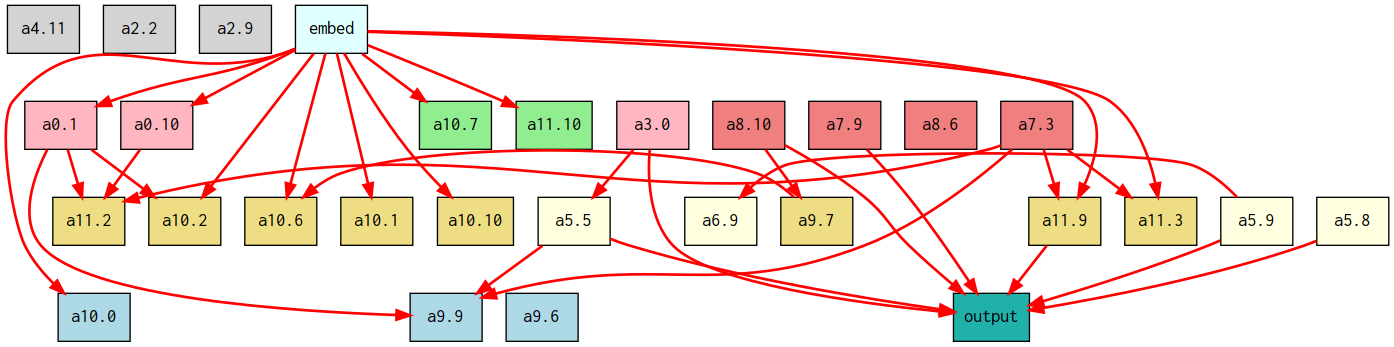

sufficient


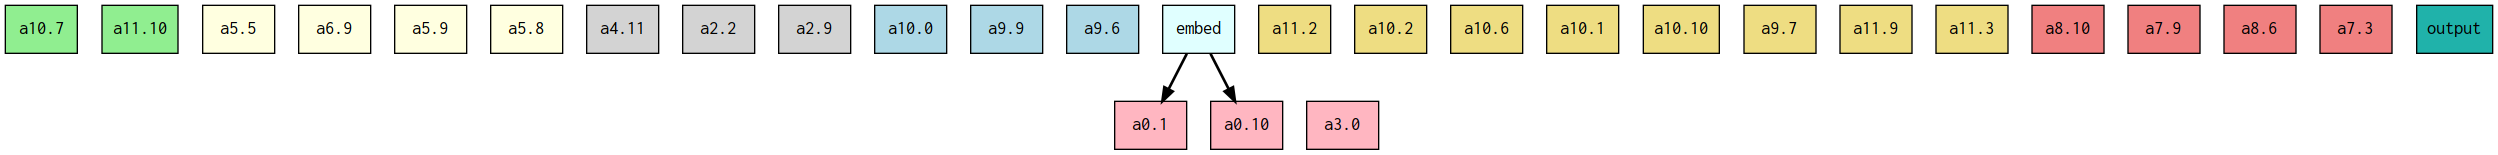

acdcpp


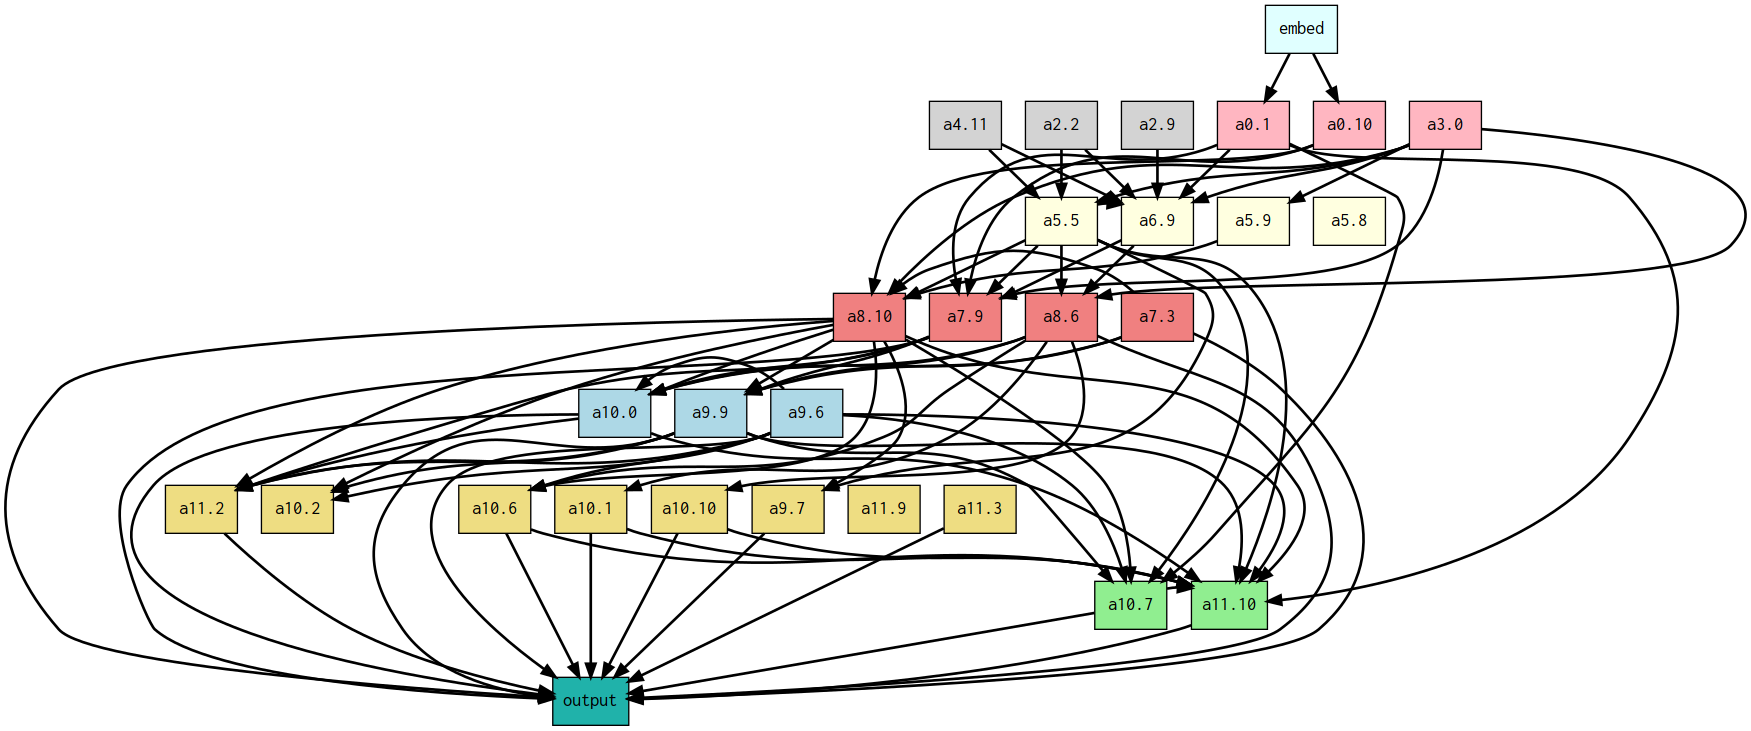

circuit_breaking


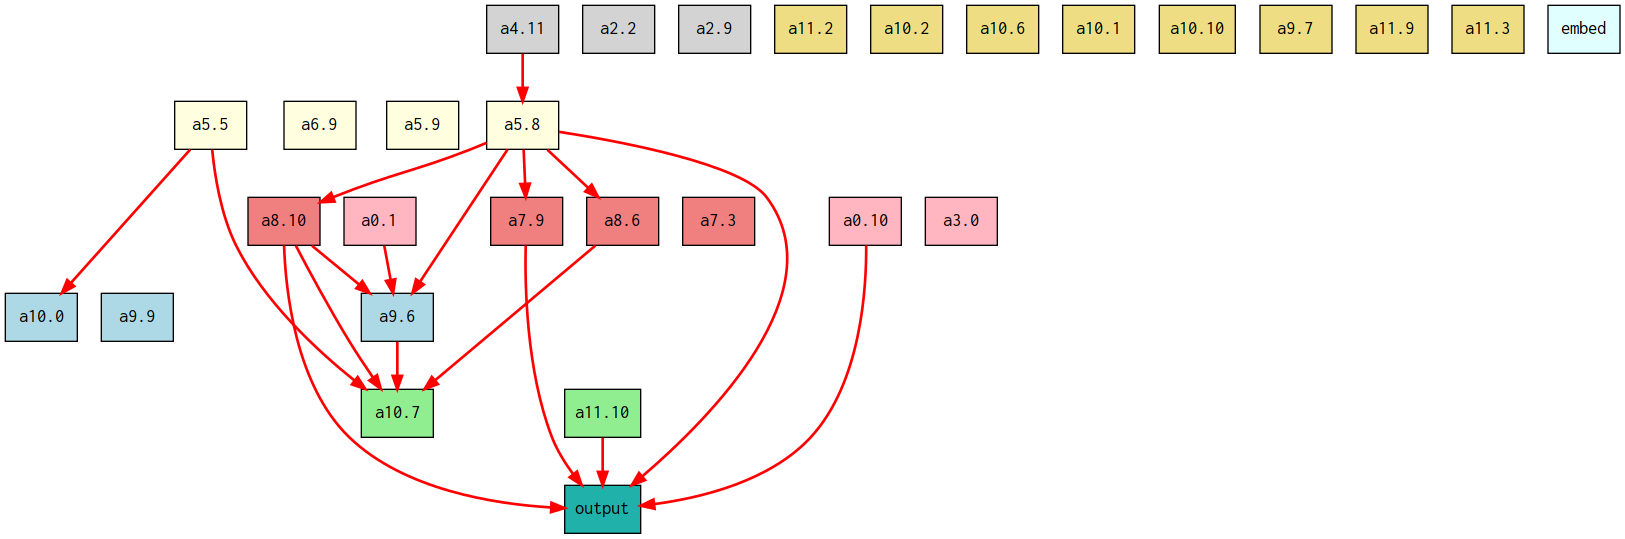

necessary_circuit_covering


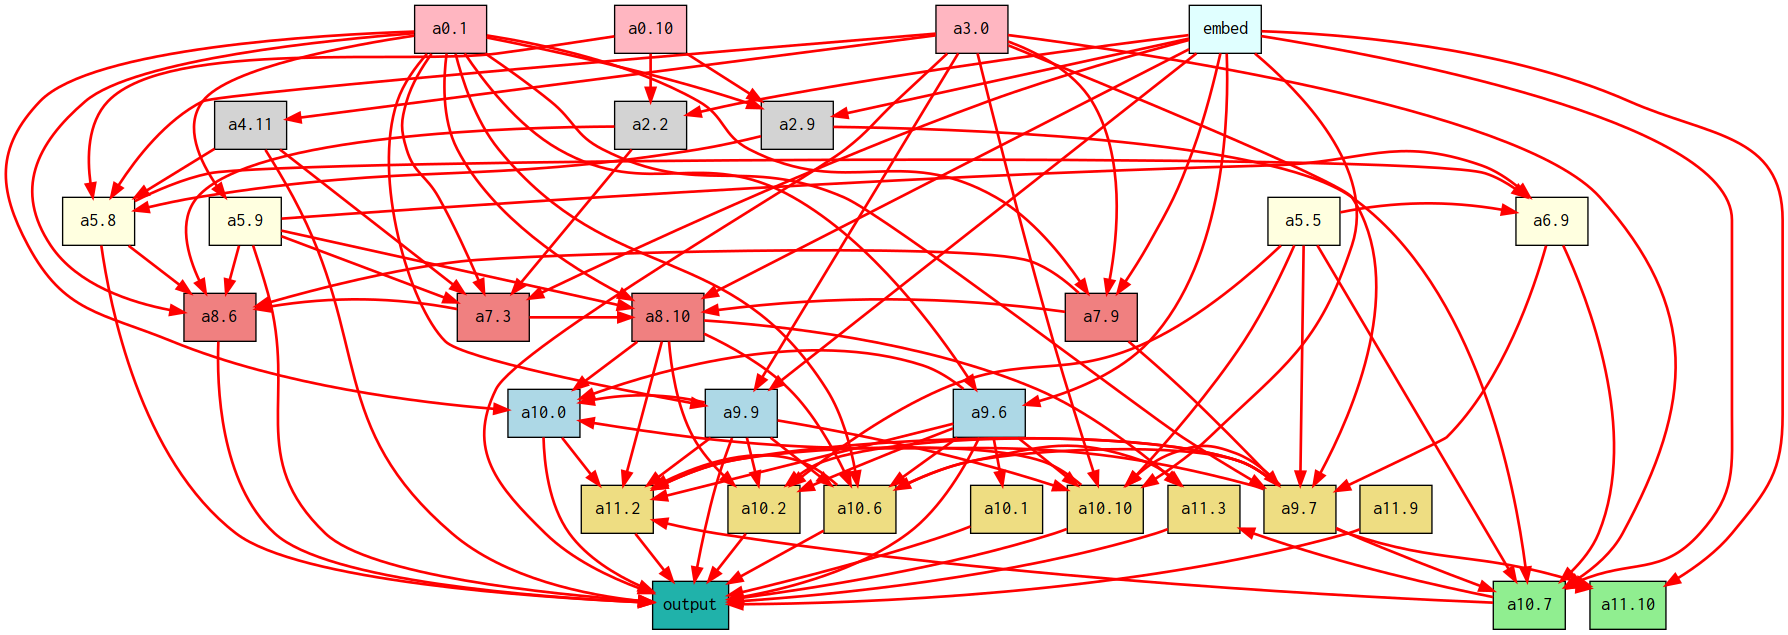

cb_circuit_covering


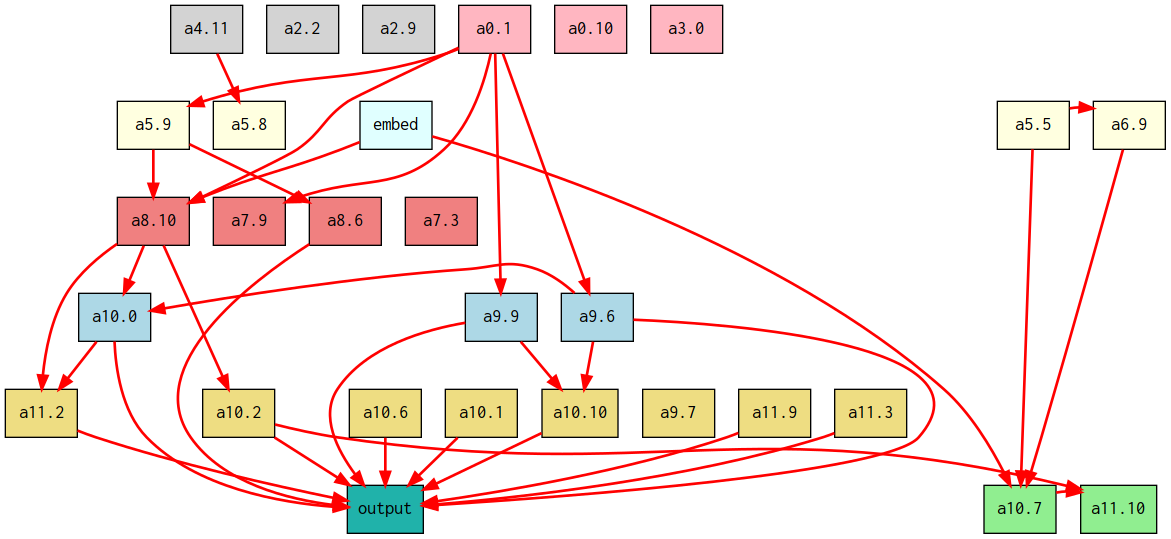

In [76]:
import pygraphviz as pgv
from IPython.display import Image, display

# Graph with a given dictionary of nodes (group is key, values are sets of nodes) and a dictionary of sets of edges (color is key, values are sets of edges)
group_colors = {
    'name_mover': 'lightblue',
    'negative': 'lightgreen',
    's2_inhibition': 'lightcoral',
    'induction': 'lightyellow',
    'duplicate_token': 'lightpink',
    'previous_token': 'lightgray',
    'backup_name_mover': 'lightgoldenrod',
    'embed': 'lightcyan',
    'output': 'lightseagreen',
}
def save_node_positions(graph):
    with open("graphs/graph_layout.txt", 'w') as f:
        for node in graph.nodes():
            f.write(f"{node}:{graph.get_node(node).attr['pos']}\n")

# Function to load node positions
def load_node_positions(filename):
    positions = {}
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            for line in f:
                node, pos = line.strip().split(':')
                positions[node] = pos
    return positions

def show_circuit(nodes, edges, load_positions=False, save_positions=False):
    # Initialize a directed graph
    G = pgv.AGraph(strict=False, directed=True)
    
    # Load positions if the flag is set
    if load_positions:
        positions = load_node_positions("graphs/graph_layout.txt")
        # print(positions)
        # for node, pos in positions.items():
        #     if G.has_node(node):
        #         G.get_node(node).attr['pos'] = pos + "!"
        #     else:
        #         # If the node doesn't exist yet in the graph, add it with the position
        #         G.add_node(node, pos=pos + "!")


    all_nodes = set()
    # Add nodes to the graph with subgraphs for ranks
    for group, node_list in nodes.items():
        # Create an invisible edge (with style="invis") between all nodes in the same group
        for i in range(len(node_list) - 1):
            G.add_edge(node_list[i], node_list[i+1], style="invis")
        
        with G.add_subgraph(node_list, name=f"{group}") as sub:
            sub.graph_attr['rank'] = 'same'
            sub.graph_attr['label'] = group
            for node in node_list:
                G.add_node(node, label=node, fillcolor=group_colors[group], style='filled')
                all_nodes.add(node)
                # if load_positions:
                #     G.get_node(node).attr['pos'] = positions[node] + "!"

    
    # # Load positions if the flag is set
    # if load_positions:
    #     positions = load_node_positions("graphs/graph_layout.txt")
    #     for node, pos in positions.items():
    #         if G.has_node(node):
    #             G.get_node(node).attr['pos'] = pos

    # Add edges to the graph
    for color, edge_set in edges.items():
        for start, end in edge_set:
            if start[1] in all_nodes and end[1] in all_nodes:
                # check if edge is in any of the later edge sets

                G.add_edge(end[1], start[1], color=color)


    # Apply styling to the graph
    G.node_attr['shape'] = 'box'
    G.node_attr['style'] = 'filled'
    G.node_attr['fillcolor'] = 'lightgrey'
    G.edge_attr['penwidth'] = 2

    if not load_positions:
        G.layout(prog='dot')

    if save_positions:
        # Save the node positions
        save_node_positions(G)
    # Generate and save the graph visualization
    # G.draw(prog='neato' if load_positions else 'dot', args='-n')
    return G

for mask_type in edges_dict:
    print(mask_type)
    if 'necessary' in mask_type or 'circuit_breaking' in mask_type or 'cb_circuit_covering' in mask_type:
        edge_color_dict = {'red': edges_dict[mask_type]}
    else:
        edge_color_dict = {'black': edges_dict[mask_type]}
    g = show_circuit(circuit_node_groups, edge_color_dict, )
    display(Image(g.draw(format='png', prog='dot')))


necessary


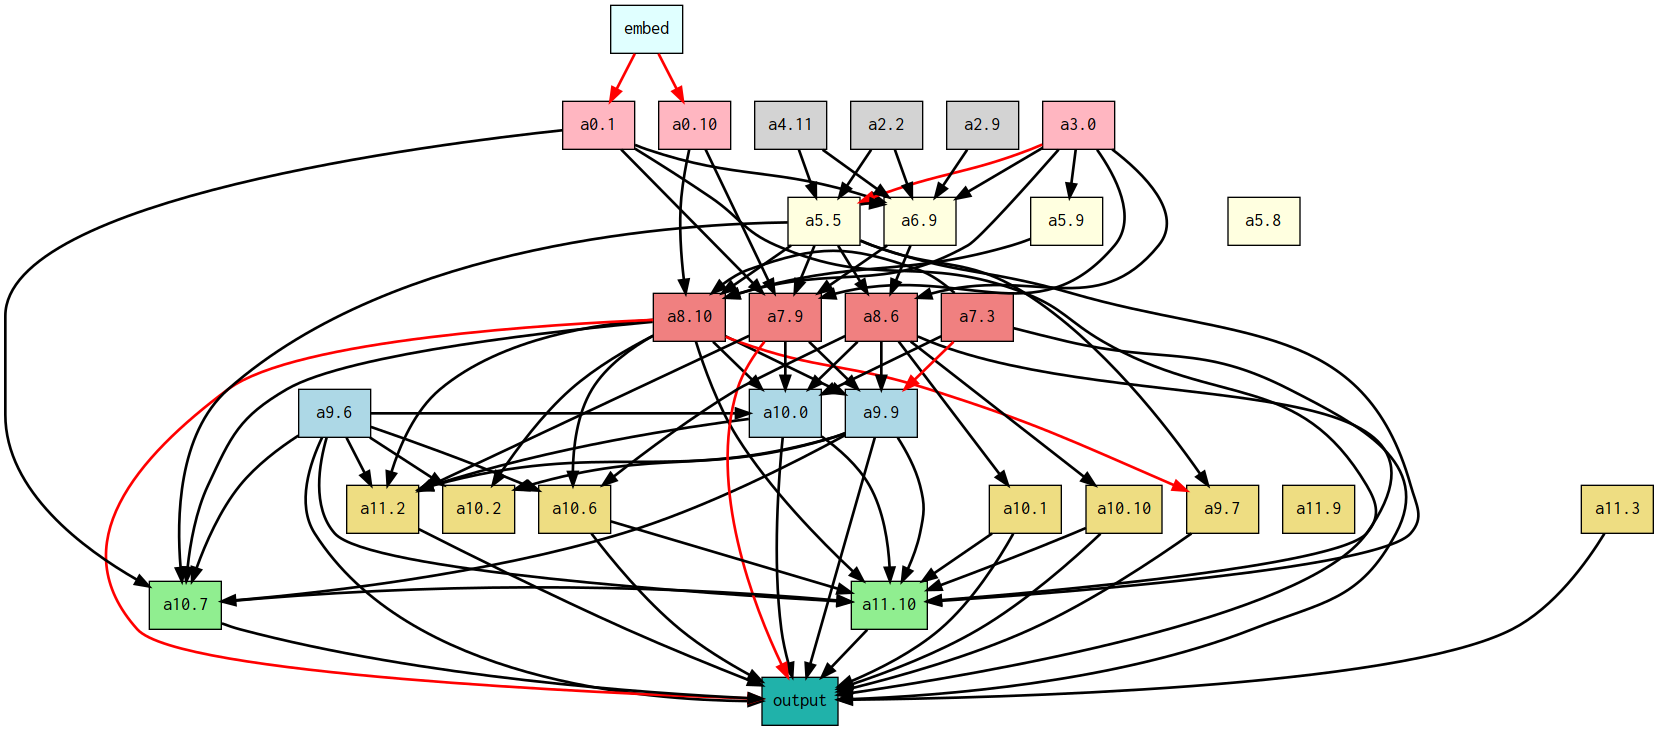

circuit_breaking


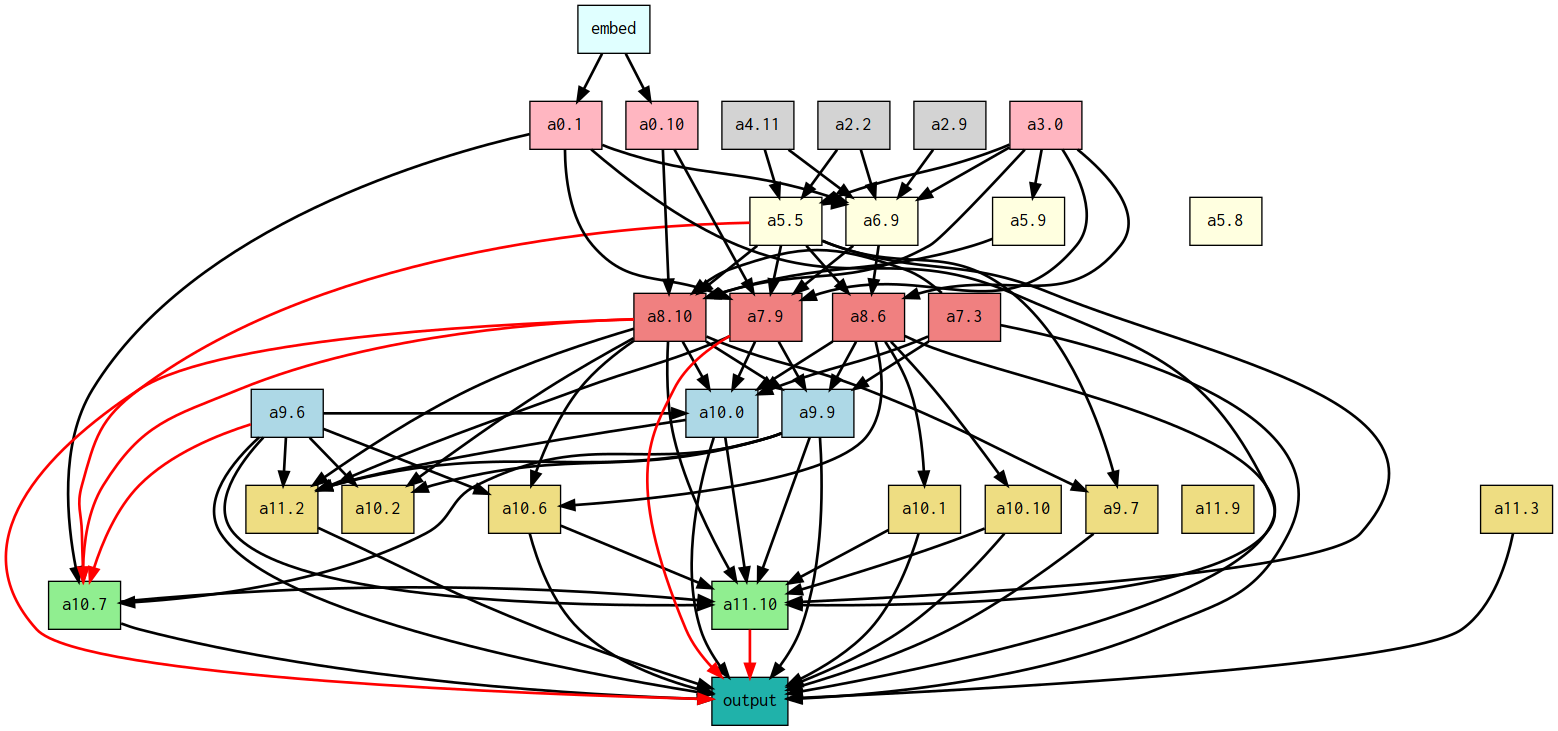

cb_circuit_covering


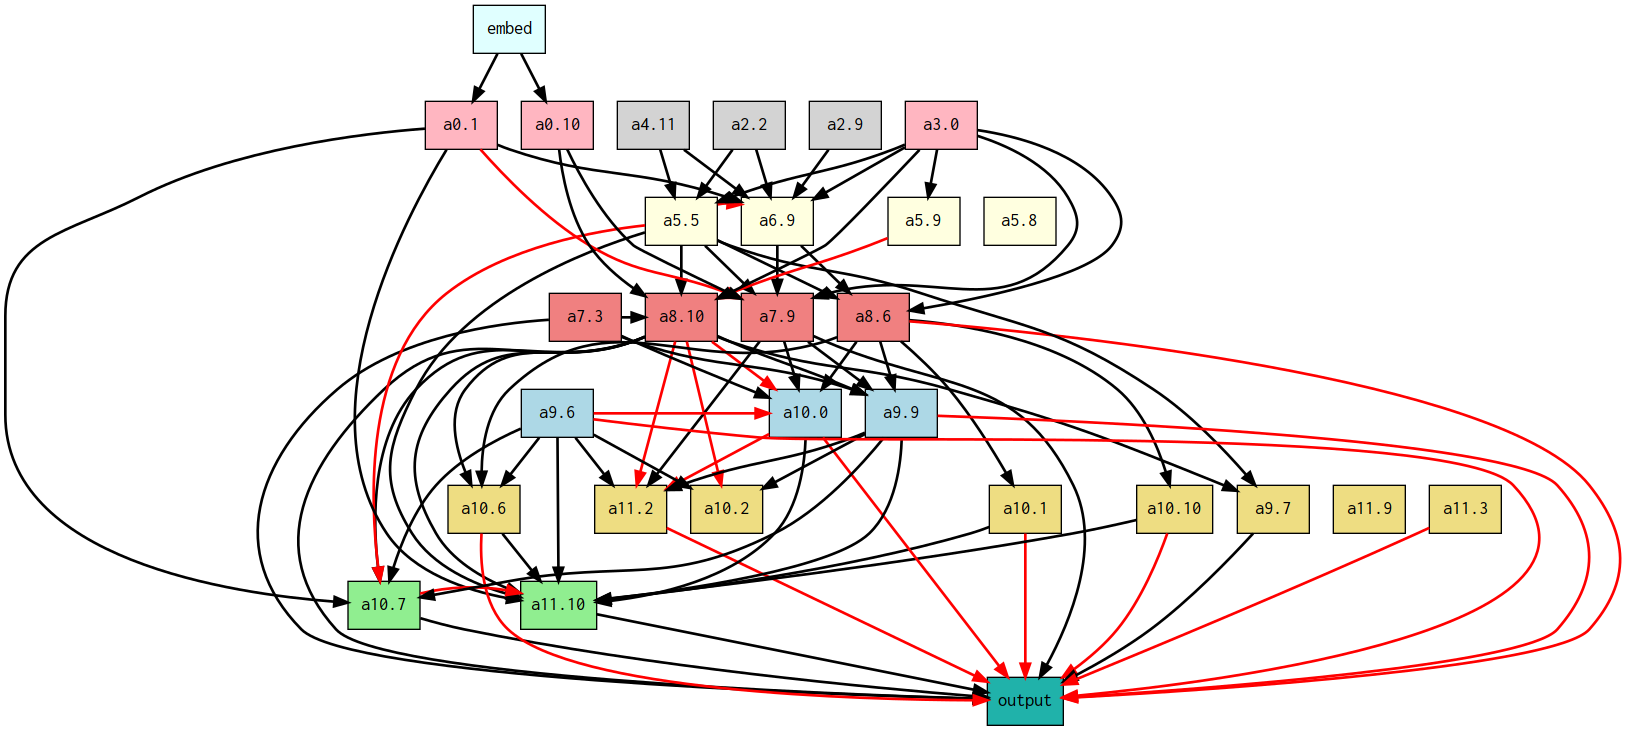

necessary_circuit_covering


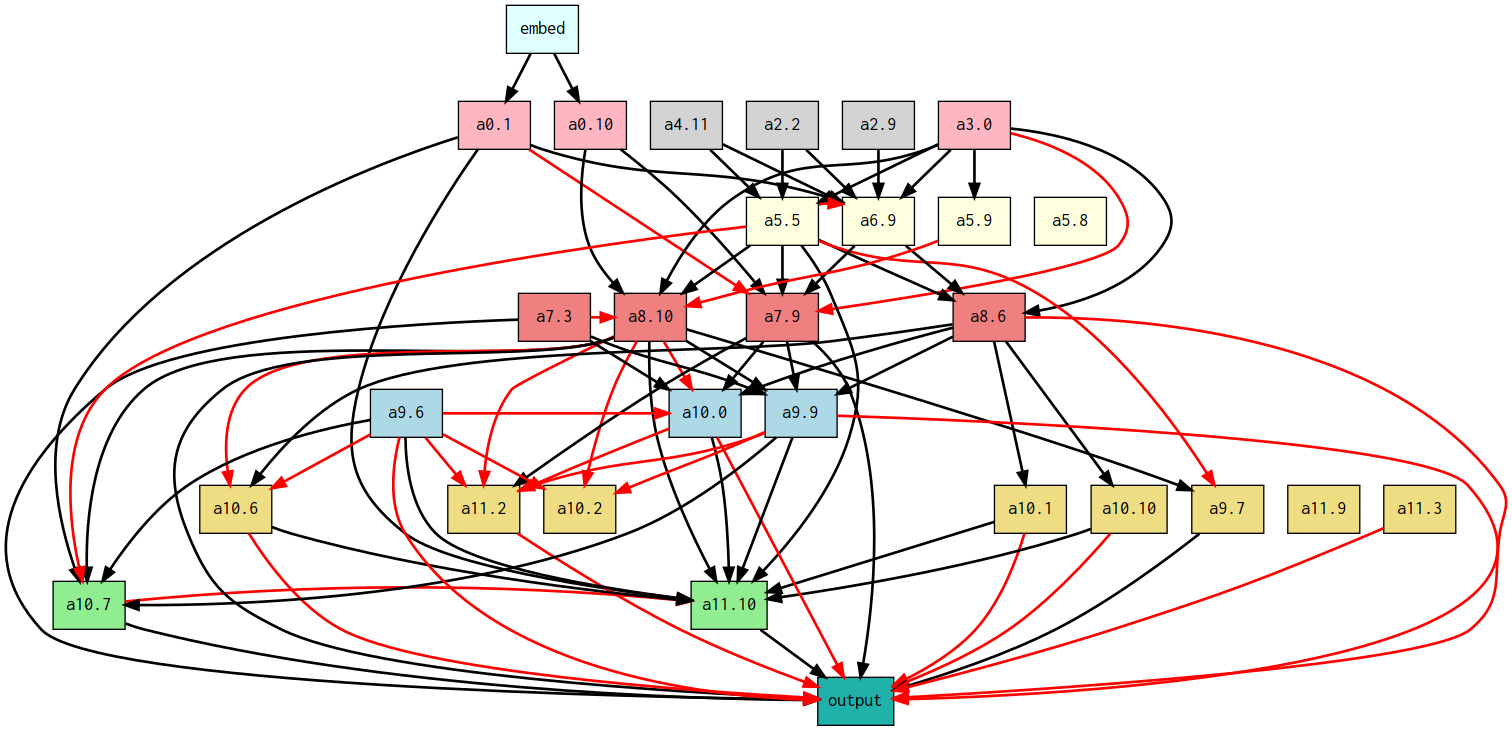

In [77]:
# Cut ACDC++ Circuit
# Show regular circuit but make some edges red if they are in the later set

for mask_type in ['necessary', 'circuit_breaking', 'cb_circuit_covering', 'necessary_circuit_covering']:
    print(mask_type)
    
    edge_color_dict = {'black': edges_dict['acdcpp'].difference(edges_dict[mask_type])}
    edge_color_dict['red'] = edges_dict[mask_type].intersection(edges_dict['acdcpp'])
    g = show_circuit(circuit_node_groups, edge_color_dict, load_positions=True, save_positions=False)
    display(Image(g.draw(format='png', prog="dot")))


## Analyze mask throughout training